In [1]:
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime
import time

plt.style.use('classic')
%matplotlib inline
sns.set()

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Functions

In [2]:
def test_binary_clf(clf, X_test, y_test):
    
    y_pred = clf.predict(X_test)
    
    print('Accuracy: %s' % accuracy_score(y_test, y_pred), end='\n\n')
    print('F1-score: %s' % f1_score(y_test, y_pred, average=None), end='\n\n')
    print('Weighted Average F1-score: %s' % f1_score(y_test, y_pred, average='weighted'), end='\n\n')
    print(classification_report(y_test, y_pred), end='\n\n')

    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues', fmt = '', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.show()
    
    print("\n")

    y_score = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='$AUC$ = %.3f' % (roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    return y_pred

# Dataset

In [3]:
df_predictions_2021 = pd.read_csv("/gdrive/My Drive/TextAnalytics/datasets/df_predictions_2021.csv")

df_predictions_2021['date'] = pd.to_datetime(df_predictions_2021['date'])
df_predictions_2021 = df_predictions_2021.set_index(['date']).sort_index()

df_predictions_2021

,tweets_volume,median_polarity,weighted_mean_polarity,vader_sentiment_mode,transformers_sentiment_mode,close,returns,up_down,volatility,up_down_next2min
date,,,,,,,,,,
2021-02-05 14:56:00,1,-0.58590,-0.585900,0,0,38199.36,-0.060402,-1,0.097788,1.0
2021-02-05 14:59:00,1,-0.34000,-0.340000,0,1,38153.19,-0.048241,-1,0.097983,1.0
2021-02-05 15:00:00,1,-0.57190,-0.571900,0,0,38192.10,0.101932,1,0.098151,-1.0
2021-02-05 15:01:00,1,-0.63670,-0.636700,0,1,38209.04,0.044345,1,0.098109,-1.0
2021-02-05 15:06:00,1,-0.59450,-0.594500,0,0,38132.74,-0.066037,-1,0.097260,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-07-30 23:53:00,12,-0.37765,-0.437077,0,1,41955.18,0.150583,1,0.217409,-1.0
2021-07-30 23:54:00,8,-0.37095,-0.561877,0,0,42203.04,0.589035,1,0.220254,-1.0
2021-07-30 23:55:00,10,-0.43380,-0.394789,0,1,42130.00,-0.173218,-1,0.220638,1.0


## Up_Down_next2min Prediction

In [4]:
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

## Train Test Split

In [5]:
train_test_split_date = "2021-07-27 00:00:00"
X_cols = ["tweets_volume", "median_polarity", "weighted_mean_polarity", "vader_sentiment_mode", "transformers_sentiment_mode", "returns", "volatility", "up_down"]
y_col = "up_down_next2min"

X_train = df_predictions_2021[X_cols].loc[df_predictions_2021.index < train_test_split_date].copy()
y_train = df_predictions_2021[y_col].loc[df_predictions_2021.index < train_test_split_date].copy()
X_test = df_predictions_2021[X_cols].loc[df_predictions_2021.index >= train_test_split_date].copy()
y_test = df_predictions_2021[y_col].loc[df_predictions_2021.index >= train_test_split_date].copy()

In [6]:
X_train

,tweets_volume,median_polarity,weighted_mean_polarity,vader_sentiment_mode,transformers_sentiment_mode,returns,volatility,up_down
date,,,,,,,,
2021-02-05 14:56:00,1,-0.5859,-0.585900,0,0,-0.060402,0.097788,-1
2021-02-05 14:59:00,1,-0.3400,-0.340000,0,1,-0.048241,0.097983,-1
2021-02-05 15:00:00,1,-0.5719,-0.571900,0,0,0.101932,0.098151,1
2021-02-05 15:01:00,1,-0.6367,-0.636700,0,1,0.044345,0.098109,1
2021-02-05 15:06:00,1,-0.5945,-0.594500,0,0,-0.066037,0.097260,-1
...,...,...,...,...,...,...,...,...
2021-07-26 23:52:00,1,0.8289,0.828900,1,1,-0.176217,0.256817,-1
2021-07-26 23:53:00,1,-0.6908,-0.690800,0,0,0.065173,0.256800,1
2021-07-26 23:54:00,2,0.0180,0.150815,1,1,0.116749,0.256544,1


In [7]:
y_train.value_counts(normalize=True)

 1.0    0.504851
-1.0    0.495149
Name: up_down_next2min, dtype: float64

In [8]:
X_test

,tweets_volume,median_polarity,weighted_mean_polarity,vader_sentiment_mode,transformers_sentiment_mode,returns,volatility,up_down
date,,,,,,,,
2021-07-27 00:00:00,1,0.90810,0.908100,1,1,-0.038730,0.256745,-1
2021-07-27 00:03:00,2,0.90100,0.852402,1,1,-0.055921,0.255951,-1
2021-07-27 00:04:00,1,0.90810,0.908100,1,1,0.086933,0.255795,1
2021-07-27 00:05:00,2,0.01430,0.154321,1,1,0.376267,0.253998,1
2021-07-27 00:07:00,2,-0.67025,-0.680295,0,0,0.317957,0.254563,1
...,...,...,...,...,...,...,...,...
2021-07-30 23:53:00,12,-0.37765,-0.437077,0,1,0.150583,0.217409,1
2021-07-30 23:54:00,8,-0.37095,-0.561877,0,0,0.589035,0.220254,1
2021-07-30 23:55:00,10,-0.43380,-0.394789,0,1,-0.173218,0.220638,-1


In [9]:
y_test.value_counts(normalize=True)

 1.0    0.51837
-1.0    0.48163
Name: up_down_next2min, dtype: float64

### Random Forest

In [10]:
pipeline = Pipeline([
                     ('clf', RandomForestClassifier())  # learning classifier
                     ])

In [11]:
r_param_grid = [
                {'clf__max_depth': list(range(5, 15))}
                ]


optr_search = RandomizedSearchCV(pipeline, r_param_grid, cv=3, n_iter=5, n_jobs=4, verbose=True).fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   25.2s finished


In [12]:
optr_search.best_params_

{'clf__max_depth': 9}

In [13]:
optr_search.cv_results_

{'mean_fit_time': array([6.54140894, 5.96924146, 7.08951839, 4.91207226, 3.38893358]),
 'mean_score_time': array([0.3091797 , 0.28521768, 0.31893714, 0.25468278, 0.14627695]),
 'mean_test_score': array([0.50608573, 0.50476274, 0.50332216, 0.50579173, 0.50490974]),
 'param_clf__max_depth': masked_array(data=[9, 8, 10, 6, 5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__max_depth': 9},
  {'clf__max_depth': 8},
  {'clf__max_depth': 10},
  {'clf__max_depth': 6},
  {'clf__max_depth': 5}],
 'rank_test_score': array([1, 4, 5, 2, 3], dtype=int32),
 'split0_test_score': array([0.50696772, 0.50687952, 0.50599753, 0.50538014, 0.50396895]),
 'split1_test_score': array([0.50626213, 0.50105839, 0.49876521, 0.50926089, 0.50696772]),
 'split2_test_score': array([0.50502734, 0.50635033, 0.50520374, 0.50273417, 0.50379256]),
 'std_fit_time': array([0.19548676, 0.2338888 , 0.24206426, 0.12904694, 0.45192566]),
 'std_score_t

In [14]:
best_pipe = optr_search.best_estimator_

In [15]:
best_pipe

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=9, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [16]:
best_pipe.predict(X_test)

array([-1.,  1., -1., ..., -1., -1., -1.])

Accuracy: 0.5076013513513513

F1-score: [0.39460021 0.58505338]

Weighted Average F1-score: 0.49332540615498266

              precision    recall  f1-score   support

        -1.0       0.48      0.33      0.39      2281
         1.0       0.52      0.67      0.59      2455

    accuracy                           0.51      4736
   macro avg       0.50      0.50      0.49      4736
weighted avg       0.50      0.51      0.49      4736




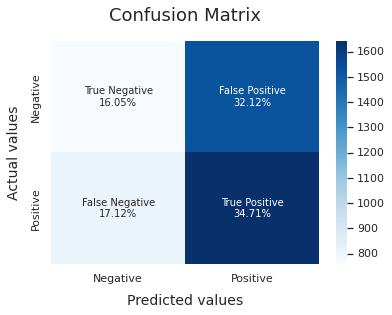

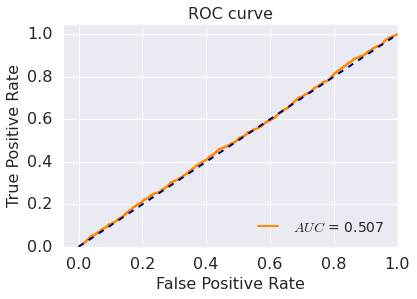

In [17]:
y_pred = test_binary_clf(best_pipe, X_test, y_test)